In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os

In [3]:
np.random.seed(42)

In [4]:
def generate_activity_data(activity, n_samples=1000):
    
    if activity == 'walking':
       
        x = np.random.normal(0.5, 0.3, n_samples) + 0.3 * np.sin(np.linspace(0, 20*np.pi, n_samples))
        y = np.random.normal(0.3, 0.25, n_samples) + 0.2 * np.sin(np.linspace(0, 20*np.pi, n_samples))
        z = np.random.normal(9.8, 0.4, n_samples) + 0.5 * np.sin(np.linspace(0, 20*np.pi, n_samples))
        
    elif activity == 'jogging':
       
        x = np.random.normal(1.0, 0.6, n_samples) + 0.8 * np.sin(np.linspace(0, 40*np.pi, n_samples))
        y = np.random.normal(0.5, 0.5, n_samples) + 0.6 * np.sin(np.linspace(0, 40*np.pi, n_samples))
        z = np.random.normal(9.8, 0.8, n_samples) + 1.2 * np.sin(np.linspace(0, 40*np.pi, n_samples))
        
    elif activity == 'sitting':
        
        x = np.random.normal(0.0, 0.1, n_samples)
        y = np.random.normal(0.0, 0.1, n_samples)
        z = np.random.normal(9.8, 0.15, n_samples)
    
    return pd.DataFrame({
        'accel_x': x,
        'accel_y': y,
        'accel_z': z,
        'activity': activity
    })

In [5]:
print("Generating synthetic accelerometer data...")
data_walking = generate_activity_data('walking', 1500)
data_jogging = generate_activity_data('jogging', 1500)
data_sitting = generate_activity_data('sitting', 1500)


df = pd.concat([data_walking, data_jogging, data_sitting], ignore_index=True)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nDataset shape: {df.shape}")
print(f"\nActivity distribution:\n{df['activity'].value_counts()}")
print(f"\nFirst few rows:\n{df.head()}")

Generating synthetic accelerometer data...

Dataset shape: (4500, 4)

Activity distribution:
activity
jogging    1500
sitting    1500
walking    1500
Name: count, dtype: int64

First few rows:
    accel_x   accel_y    accel_z activity
0  1.029176  0.705815  10.967635  jogging
1 -0.188298  0.100337   9.430935  sitting
2  0.575928 -0.066866   9.415583  jogging
3 -0.041958 -0.133543   9.011819  jogging
4  0.549056  0.390077   9.965192  walking



EXPLORATORY DATA ANALYSIS

Statistical Summary:
         accel_x                                                              \
           count      mean       std       min       25%       50%       75%   
activity                                                                       
jogging   1500.0  0.980402  0.816700 -1.694094  0.408645  0.990858  1.558147   
sitting   1500.0 -0.000939  0.096029 -0.392240 -0.065978  0.000486  0.063663   
walking   1500.0  0.514715  0.363893 -0.772352  0.260501  0.521959  0.765465   

                   accel_y            ...                     accel_z  \
               max   count      mean  ...       75%       max   count   
activity                              ...                               
jogging   3.631901  1500.0  0.491666  ...  0.960200  2.605613  1500.0   
sitting   0.291411  1500.0 -0.003270  ...  0.062808  0.337777  1500.0   
walking   1.840788  1500.0  0.303738  ...  0.509685  1.469218  1500.0   

                               

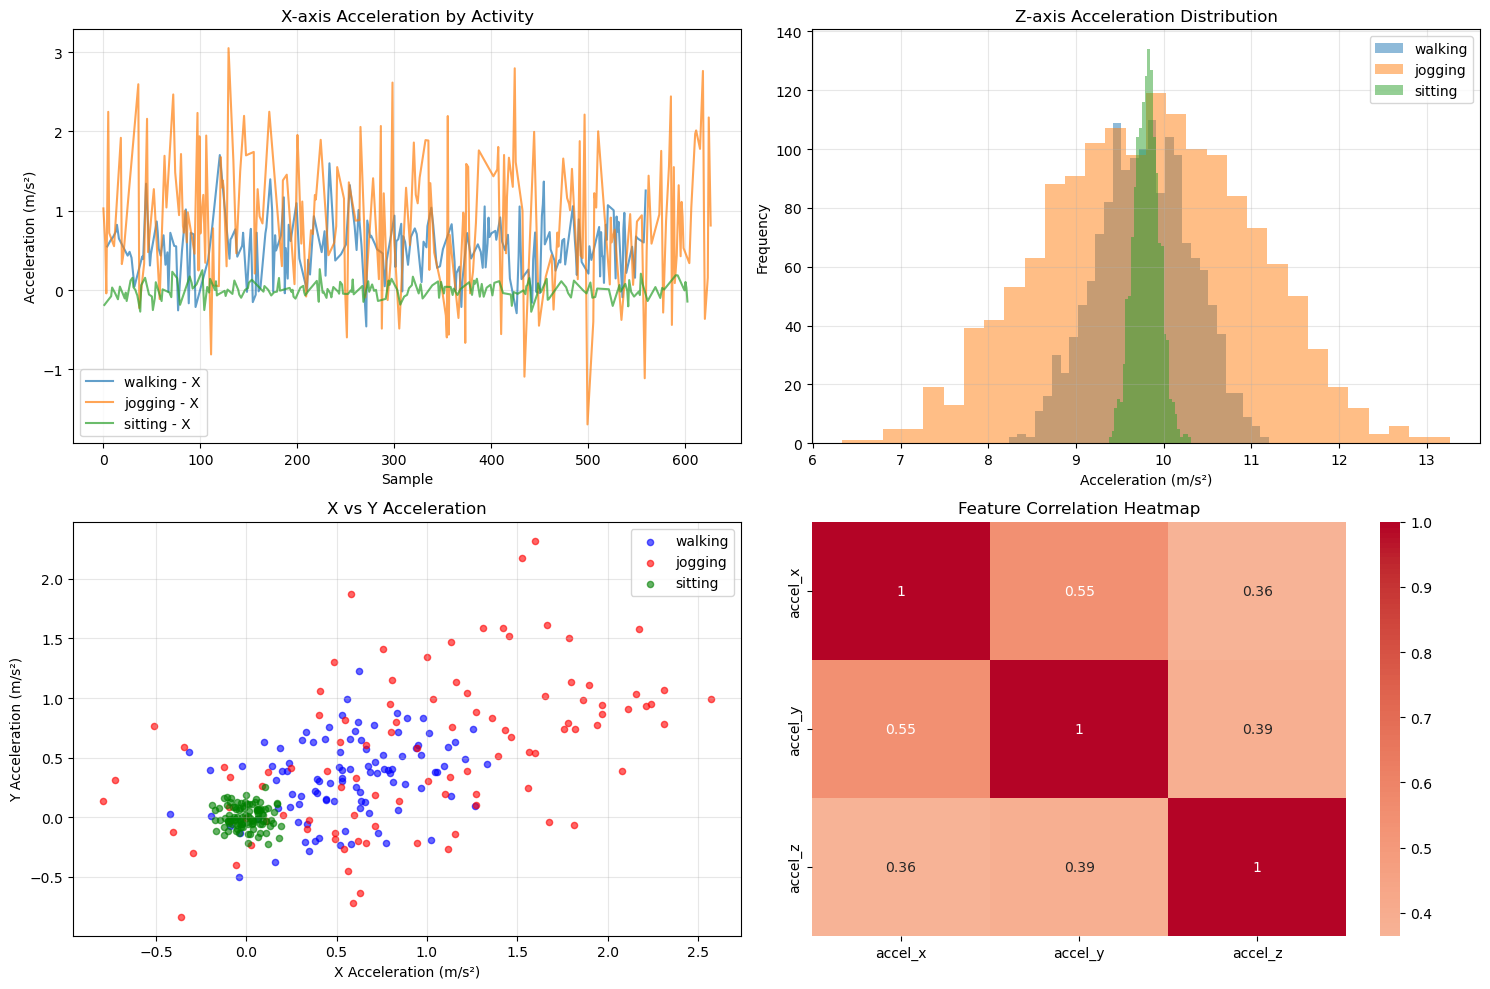

In [10]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

print("\nStatistical Summary:")
print(df.groupby('activity')[['accel_x', 'accel_y', 'accel_z']].describe())


fig, axes = plt.subplots(2, 2, figsize=(15, 10))


for activity in ['walking', 'jogging', 'sitting']:
    activity_data = df[df['activity'] == activity].iloc[:200]
    axes[0, 0].plot(activity_data['accel_x'], label=f'{activity} - X', alpha=0.7)

axes[0, 0].set_title('X-axis Acceleration by Activity')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Acceleration (m/s²)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


for activity in ['walking', 'jogging', 'sitting']:
    activity_data = df[df['activity'] == activity]
    axes[0, 1].hist(activity_data['accel_z'], bins=30, alpha=0.5, label=activity)

axes[0, 1].set_title('Z-axis Acceleration Distribution')
axes[0, 1].set_xlabel('Acceleration (m/s²)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)


colors = {'walking': 'blue', 'jogging': 'red', 'sitting': 'green'}
for activity in ['walking', 'jogging', 'sitting']:
    activity_data = df[df['activity'] == activity].sample(100)
    axes[1, 0].scatter(activity_data['accel_x'], activity_data['accel_y'], 
                       c=colors[activity], label=activity, alpha=0.6, s=20)

axes[1, 0].set_title('X vs Y Acceleration')
axes[1, 0].set_xlabel('X Acceleration (m/s²)')
axes[1, 0].set_ylabel('Y Acceleration (m/s²)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

correlation = df[['accel_x', 'accel_y', 'accel_z']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()


In [11]:
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

df['magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)
df['xy_magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2)
window_size = 10
df['x_rolling_mean'] = df['accel_x'].rolling(window=window_size, min_periods=1).mean()
df['y_rolling_mean'] = df['accel_y'].rolling(window=window_size, min_periods=1).mean()
df['z_rolling_mean'] = df['accel_z'].rolling(window=window_size, min_periods=1).mean()
df['x_rolling_std'] = df['accel_x'].rolling(window=window_size, min_periods=1).std().fillna(0)
df['y_rolling_std'] = df['accel_y'].rolling(window=window_size, min_periods=1).std().fillna(0)

print(f"\nFeatures created: {df.columns.tolist()}")
print(f"\nDataset shape after feature engineering: {df.shape}")



FEATURE ENGINEERING

Features created: ['accel_x', 'accel_y', 'accel_z', 'activity', 'magnitude', 'xy_magnitude', 'x_rolling_mean', 'y_rolling_mean', 'z_rolling_mean', 'x_rolling_std', 'y_rolling_std']

Dataset shape after feature engineering: (4500, 11)


In [12]:
print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

feature_columns = ['accel_x', 'accel_y', 'accel_z', 'magnitude', 'xy_magnitude',
                   'x_rolling_mean', 'y_rolling_mean', 'z_rolling_mean',
                   'x_rolling_std', 'y_rolling_std']

X = df[feature_columns]
y = df['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



MODEL TRAINING
Training set size: 3600
Test set size: 900


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


Training Random Forest Classifier...


In [14]:
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


MODEL EVALUATION

Accuracy: 0.8667 (86.67%)

Classification Report:
              precision    recall  f1-score   support

     jogging       0.88      0.79      0.83       300
     sitting       0.94      0.99      0.96       300
     walking       0.79      0.83      0.81       300

    accuracy                           0.87       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.87      0.87      0.87       900



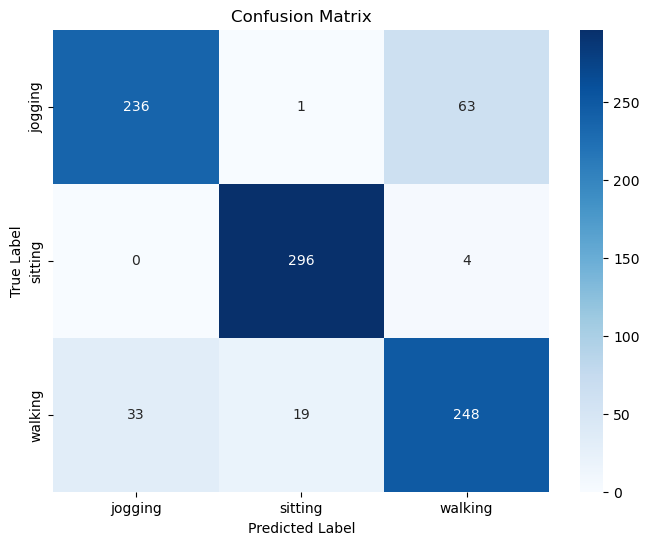

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['jogging', 'sitting', 'walking'],
            yticklabels=['jogging', 'sitting', 'walking'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

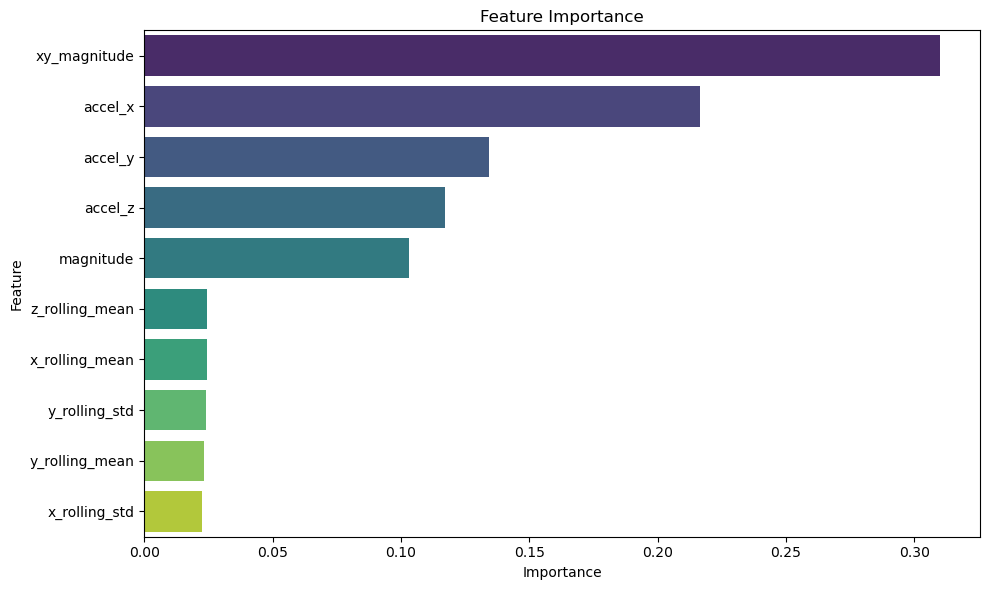


Feature Importance:
          feature  importance
4    xy_magnitude    0.310057
0         accel_x    0.216586
1         accel_y    0.134144
2         accel_z    0.117206
3       magnitude    0.102963
7  z_rolling_mean    0.024600
5  x_rolling_mean    0.024482
9   y_rolling_std    0.024276
6  y_rolling_mean    0.023342
8   x_rolling_std    0.022344


In [16]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

In [17]:
joblib.dump(model, 'fitness_classifier_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

df.to_csv('fitness_data.csv', index=False)

print("\n Model saved to: fitness_classifier_model.pkl")
print(" Scaler saved to: scaler.pkl")
print(" Data saved to: fitness_data.csv")



 Model saved to: fitness_classifier_model.pkl
 Scaler saved to: scaler.pkl
 Data saved to: fitness_data.csv
